In [2]:
import os
import sys
import glob
import pickle
from tqdm import tqdm
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt, lombscargle
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline

import tensorflow as tf
from tensorflow import keras

if '..' not in sys.path:
    sys.path.append('..')
from dlml.utils import collect_experiments
from dlml.data import read_area_values, load_data_areas, load_data_files
from dlml.nn import predict, DownSampling1D, SpectralPooling, MaxPooling1DWithArgmax

In [3]:
def plot_layer_output_hist(Y, group_index, N_bins, cols=8, w=2, h=1.5, cmap=None, ax=None, labels=None):
    N_trials, N_samples, N_filters = Y.shape
    N_groups = len(group_index)
    N = np.zeros((N_filters, N_groups, N_bins))
    edges = np.zeros((N_filters, N_groups, N_bins+1))
    for i in range(N_filters):
        for j,jdx in enumerate(group_index):
            N[i,j,:],edges[i,j,:] = np.histogram(Y[jdx, :, i], N_bins)

    if cmap is None:
        cmap = plt.get_cmap('tab10', N_groups)
    if ax is None:
        rows = N_filters // cols
        fig,ax = plt.subplots(rows, cols, figsize=(w*cols, h*rows))
    else:
        fig = None
        N_filters = ax.size
    ax = ax.flatten()
    for i in range(N_filters):
        for j in range(N_groups):
            de = np.diff(edges[i, j, :])[0]
            col = np.max([[0,0,0], cmap(j)[:3] - 1/3 * np.ones(3)], axis=0)
            ax[i].bar(edges[i, j, :-1], N[i, j, :], width=de*0.8, align='edge',
                     facecolor=cmap(j), edgecolor=col, linewidth=0.5, alpha=0.75)
        xlim = [edges[i, :, 2:-3].min(), edges[i, j, 2:-3].max()]
        ylim = ax[i].get_ylim()
#         ax[i].set_xlim(xlim)
#         ax[i].set_xticks(xlim)
        if labels is not None:
            ax[i].text(xlim[0], ylim[1], labels[i], fontsize=7, verticalalignment='top',
                      horizontalalignment='left')
        ax[i].set_xticklabels([])
        ax[i].set_yticks(ax[i].get_ylim())
        ax[i].set_yticklabels([])
        for side in 'right','top':
            ax[i].spines[side].set_visible(False)
    if fig is not None:
        fig.tight_layout()
    return fig,ax

In [4]:
def plot_layer_output_ci(Y, group_index, cols=8, w=2, h=1.5, cmap=None, ax=None):
    N_trials, N_samples, N_filters = Y.shape
    N_groups = len(group_index)
    mean = np.array([[Y[idx, :, i].mean(axis=0) for idx in group_index] for i in range(N_filters)])
    ci = np.array([[1.96 * Y[idx, :, i].std(axis=0) / np.sqrt(idx.size) \
                    for idx in group_index] for i in range(N_filters)])
    if cmap is None:
        cmap = plt.get_cmap('tab10', N_groups)
    if ax is None:
        rows = N_filters // cols
        fig,ax = plt.subplots(rows, cols, figsize=(w*cols, h*rows), sharex=True)
    else:
        fig = None
        N_filters = ax.size
    ax = ax.flatten()
    for i in range(N_filters):
        for j in range(N_groups):
            x = np.arange(mean.shape[-1])
            ax[i].fill_between(x, mean[i, j, :] + ci[i, j, :], mean[i, j, :] - ci[i, j, :],
                                 color=cmap(j), alpha=0.75)
            ax[i].set_xticks(x[[0,-1]])
            ax[i].set_xticklabels(x[[0,-1]]+1)
            ax[i].set_yticks(ax[i].get_ylim())
            ax[i].set_yticklabels([])
            ax[i].grid(which='major', axis='y', ls=':', lw=0.5, color=[.6,.6,.6])
            for side in 'right','top':
                ax[i].spines[side].set_visible(False)
    if fig is not None:
        fig.tight_layout()
    return fig,ax

#### Find the best experiment given a set of tags

In [5]:
area_ID = 1
area_measure = 'momentum'
stoch_load_bus_IDs = []
rec_bus_IDs = [3]
H_G1, D, DZA = None, None, None # 500, 2, 0
additional_tags = ['ReLU_none', 'converted_from_PowerFactory', 'all_stoch_loads', 'data_subset']
missing_tags = []
use_FFT = False
if use_FFT:
    additional_tags.append('fft')
else:
    missing_tags.append('fft')
pooling_type = 'argmax'
if pooling_type is not None and pooling_type != '':
    additional_tags.append(pooling_type + '_pooling')

# training on frequency data, 2 output values
# experiment_ID = '9ea493c789b542bf979c51a6031f4044'
# training on frequency data, 4 output values
# experiment_ID = 'f6d9a03f1cfe450288e9cb86da94235f'
# training on time series data, 2 output values
# experiment_ID = '034a1edb0797475b985f0e1335dab383'
# training on time series data, 4 output values
# experiment_ID = 'b346a89d384c4db2ba4058a2c83c4f12'
# training on time series data, 2 output values, with MaxPooling1DWithArgmax layer
# experiment_ID = '9034f8bc4f874c938dfa5f1f9ee04e82'
# training on time data, 2 output values, 8 input values
experiment_ID = '98475b819ecb4d569646d7e1467d7c9c'

if experiment_ID is not None:
    from comet_ml.api import API, APIExperiment
    api = API(api_key = os.environ['COMET_API_KEY'])
    experiment = api.get_experiment('danielelinaro', 'inertia', experiment_ID)
    sys.stdout.write(f'Getting metrics for experiment {experiment_ID[:6]}... ')
    sys.stdout.flush()
    metrics = experiment.get_metrics()
    sys.stdout.write('done.\n')
    val_loss = []
    for m in metrics:
        if m['metricName'] == 'val_loss':
            val_loss.append(float(m['metricValue']))
        elif m['metricName'] == 'mape_prediction':
            MAPE = float(m['metricValue'])
    val_loss = np.array(val_loss)
else:
    # find the best experiment that matches the set of tags above
    experiments = collect_experiments(area_ID, area_measure=area_measure, D=D, DZA=DZA, \
                                      stoch_load_bus_IDs=stoch_load_bus_IDs, H_G1=H_G1, \
                                      rec_bus_IDs=rec_bus_IDs, additional_tags=additional_tags, \
                                      missing_tags=missing_tags, verbose=True)
    experiment_IDs = list(experiments.keys())
    experiment_ID = experiment_IDs[np.argmin([expt['val_loss'].min() for expt in experiments.values()])]
    experiment_ID = experiment_IDs[np.argmin([expt['MAPE'] for expt in experiments.values()])]

    MAPE = experiments[experiment_ID]['MAPE']
    loss = experiments[experiment_ID]['loss']
    val_loss = experiments[experiment_ID]['val_loss']
    batch_loss = experiments[experiment_ID]['batch_loss']
    tags = experiments[experiment_ID]['tags']
print(f'Selected experiment is {experiment_ID[:6]} (val_loss = {val_loss.min():.4f}, MAPE = {MAPE:.4f}%).')

Getting metrics for experiment 98475b... done.
Selected experiment is 98475b (val_loss = 0.0048, MAPE = 1.7915%).


#### Load the model

In [6]:
experiments_path = '../experiments/neural_network/'
network_parameters = pickle.load(open(os.path.join(experiments_path, experiment_ID, 'parameters.pkl'), 'rb'))
checkpoint_path = experiments_path + experiment_ID + '/checkpoints/'
checkpoint_files = glob.glob(checkpoint_path + '*.h5')
try:
    epochs = [int(os.path.split(file)[-1].split('.')[1].split('-')[0]) for file in checkpoint_files]
    best_checkpoint = checkpoint_files[epochs.index(np.argmin(val_loss) + 1)]
except:
    best_checkpoint = checkpoint_files[-1]
try:
    model = keras.models.load_model(best_checkpoint)
except:
    if pooling_type == 'downsample':
        custom_objects = {'DownSampling1D': DownSampling1D}
    elif pooling_type == 'spectral':
        custom_objects = {'SpectralPooling': SpectralPooling}
    elif pooling_type == 'argmax':
        custom_objects = {'MaxPooling1DWithArgmax': MaxPooling1DWithArgmax}
    with keras.utils.custom_object_scope(custom_objects):
        model = keras.models.load_model(best_checkpoint)
if pooling_type == 'argmax':
    for layer in model.layers:
        if isinstance(layer, MaxPooling1DWithArgmax):
            print(f'Setting store_argmax = True for layer "{layer.name}".')
            layer.store_argmax = True
x_train_mean = network_parameters['x_train_mean']
x_train_std  = network_parameters['x_train_std']
try:
    x_train_min = network_parameters['x_train_min']
    x_train_max = network_parameters['x_train_max']
except:
    pass
var_names = network_parameters['var_names']
print(f'Loaded network from {best_checkpoint}.')
print(f'Variable names: {var_names}')

Loaded network from ../experiments/neural_network/98475b819ecb4d569646d7e1467d7c9c/checkpoints/weights.h5.
Variable names: ['Vd_bus3']


2022-08-24 15:26:22.845758: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Plot the model topology

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Vd_bus3 (InputLayer)        [(None, 2400, 1)]         0         
                                                                 
 Vd_bus3_conv_1_1 (Conv1D)   (None, 2396, 16)          96        
                                                                 
 Vd_bus3_pool_1_1 (MaxPoolin  (None, 599, 16)          0         
 g1D)                                                            
                                                                 
 Vd_bus3_conv_1_2 (Conv1D)   (None, 595, 32)           2592      
                                                                 
 Vd_bus3_pool_1_2 (MaxPoolin  (None, 148, 32)          0         
 g1D)                                                            
                                                                 
 Vd_bus3_conv_1_3 (Conv1D)   (None, 144, 64)           10304 

#### Load the data set

In [22]:
use_fft = network_parameters['use_fft'] if 'use_fft' in network_parameters else False
if use_fft:
    raise Exception('This notebook must be used on a network that uses time-domain inputs')

use_test_set = True
with_compensators = False if use_test_set else True
set_name = 'test'

if use_test_set:
    data_dir = os.path.join('..', network_parameters['data_dirs'][0].format(network_parameters['area_IDs'][0]))
    data_files = sorted(glob.glob(data_dir + os.path.sep + f'*_{set_name}_set.h5'))
    ret = load_data_areas({set_name: data_files}, network_parameters['var_names'],
                            network_parameters['generators_areas_map'][:1],
                            network_parameters['generators_Pnom'],
                            network_parameters['area_measure'],
                            trial_dur=network_parameters['trial_duration'],
                            max_block_size=500,
                            use_tf=False, add_omega_ref=True,
                            use_fft=False)
    t = ret[0]
    X_raw = ret[1][set_name]
    y = ret[2][set_name]
    group_index = [np.where(y == mom)[0] for mom in np.unique(y)]

else:
    base_folder = network_parameters['data_dirs'][0]
    generators_areas_map = network_parameters['generators_areas_map'].copy()
    generators_areas_map[0].append('Comp11')
    generators_Pnom = network_parameters['generators_Pnom'].copy()
    generators_Pnom['Comp11'] = 100e6
    while '{}' in base_folder:
        base_folder,_ = os.path.split(base_folder)
    data_files = []
    group_index = []
    for i,prefix in enumerate(('low','high')):
        folder = os.path.join('..', base_folder, prefix + '_momentum_' + set_name)
        if with_compensators and os.path.isdir(folder + '_comp'):
            folder += '_comp'
        print(f'Loading data from {folder}...')
        files = sorted(glob.glob(folder + os.path.sep + '*.h5'))
        group_index.append(np.arange(len(files)) + len(data_files))
        data_files += files

    ret = load_data_files(data_files,
                          network_parameters['var_names'],
                          generators_areas_map[:1],
                          generators_Pnom,
                          'momentum')

    t = ret[0][:-1]
    X_raw = ret[1][:, :, :-1]
    y = ret[2]

if True:
    group_index = [np.where(y < y.mean())[0], np.where(y > y.mean())[0]]
    for idx in group_index:
        y[idx] = y[idx].mean()

X = np.zeros(X_raw.shape)
for i,(m,s) in enumerate(zip(x_train_mean, x_train_std)):
    X[i,:,:] = (X_raw[i,:,:] - m) / s
X_raw = X_raw.squeeze()
X = X.squeeze()
y = y.squeeze()
dt = np.diff(t[:2])[0]
N_samples = t.size
Xf = fft(X)
Xf = 2.0 / N_samples * np.abs(Xf[:, :N_samples//2])
F = fftfreq(N_samples, dt)[:N_samples//2]
n_mom_groups = len(group_index)

#### Predict the momentum using the model

In [23]:
y_pred = model.predict(X)
momentum = [y_pred[idx] for idx in group_index]
mean_momentum = [m.mean() for m in momentum]
stddev_momentum = [m.std() for m in momentum]
print('Mean momentum:', mean_momentum)
print(' Std momentum:', stddev_momentum)

Mean momentum: [0.18058665, 0.26850832]
 Std momentum: [0.005038687, 0.005822519]


### Plot the inputs and their FFTs

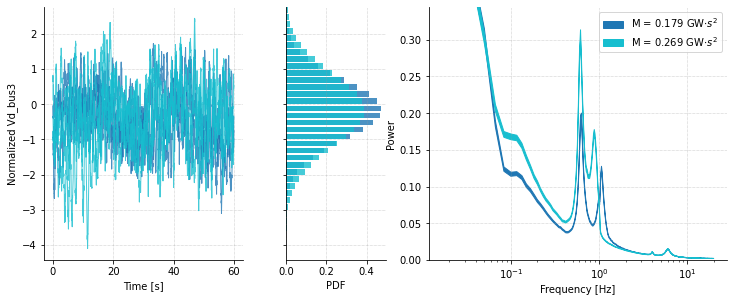

In [25]:
cmap = plt.get_cmap('tab10', n_mom_groups)

fig = plt.figure(figsize=(10,4))
gs = GridSpec(1, 3, figure=fig, width_ratios=[2, 1, 3])
ax = [fig.add_subplot(gs[0,0]), fig.add_subplot(gs[0,1]), fig.add_subplot(gs[0,2])]

for j,jdx in enumerate(group_index):
    for i in range(3):
        ax[0].plot(t, X[jdx[i]], color=cmap(j), lw=1, alpha=0.8)
    edges = np.linspace(-4, 4, 41)
    n,edges = np.histogram(X[jdx], bins=edges, density=True)
    de = np.diff(edges)[0]
    ax[1].barh(edges[1:], n, height=de*0.8, facecolor=cmap(j), align='edge', alpha=0.8)
    mean = Xf[jdx].mean(axis=0)
    stddev = Xf[jdx].std(axis=0)
    ci = 1.96 * stddev / np.sqrt(jdx.size)
    ylim = [0, np.max((mean + ci)[F > 0.1]) * 1.1]
    ax[2].fill_between(F, mean + ci, mean - ci, color=cmap(j),
                       label=r'M = {:.3f} GW$\cdot s^2$'.format(y[jdx].mean()))
for a in ax:
    for side in 'right','top':
        a.spines[side].set_visible(False)
    a.grid(which='major', axis='both', ls=':', lw=0.5, color=[.6,.6,.6])
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel(f'Normalized {var_names[0]}')
ax[1].set_ylim(ax[0].get_ylim())
ax[1].set_yticklabels([])
ax[1].set_xlabel('PDF')
ax[2].set_xscale('log')
ax[2].set_xlabel('Frequency [Hz]')
ax[2].set_ylabel('Power')
ax[2].set_ylim(ylim)
ax[2].legend(loc='upper right')
fig.tight_layout(pad=0)
fig.savefig(f'spectra_{n_mom_groups}_momentum_levels.pdf')

#### Make a model with as many outputs as there are convolutional and pooling layers

In [26]:
i = 1
while 'conv' in model.layers[i].name or 'pool' in model.layers[i].name:
    i += 1
multi_output_model = keras.Model(inputs=model.inputs,
                                 outputs=[layer.output for layer in model.layers[1:i]])
multi_output = multi_output_model.predict(X)

#### Load the correlations files

In [28]:
N_bands = 20
sort_F = 1.0
IDX = []
for layer in multi_output_model.layers[1:]:
    print(layer.name)
    continue
    _, N_neurons, N_filters = layer.output.shape
    correlations_file = f'correlations_{experiment_ID[:6]}_{N_bands}-bands_{N_filters}-filters' + \
        f'_{N_neurons}-neurons_1000-trials_8-butter_{layer.name}.npz'
    print(f'Loading {correlations_file}...')
    corr = np.load(os.path.join('..', 'experiments', 'neural_network', experiment_ID, correlations_file))
    R = corr['R']
    idx = corr['idx']
    edges = corr['edges']
    R_mean = [R[jdx].mean(axis=0) for jdx in idx]
    edge = np.abs(corr['edges'] - sort_F).argmin()
    IDX.append([np.argsort(rm[edge,:]) for rm in R_mean])

Vd_bus3_conv_1_1
Vd_bus3_pool_1_1
Vd_bus3_conv_1_2
Vd_bus3_pool_1_2
Vd_bus3_conv_1_3
Vd_bus3_pool_1_3


In [38]:
layer_names = [layer.name for layer in model.layers]
kwargs = {'group_index': group_index, 'layer_names': layer_names}
for i,out in enumerate(multi_output):
    kwargs[f'multi_output_{i}'] = out
np.savez_compressed(os.path.join(experiments_path, experiment_ID, 'layer_outputs.npz'), **kwargs)

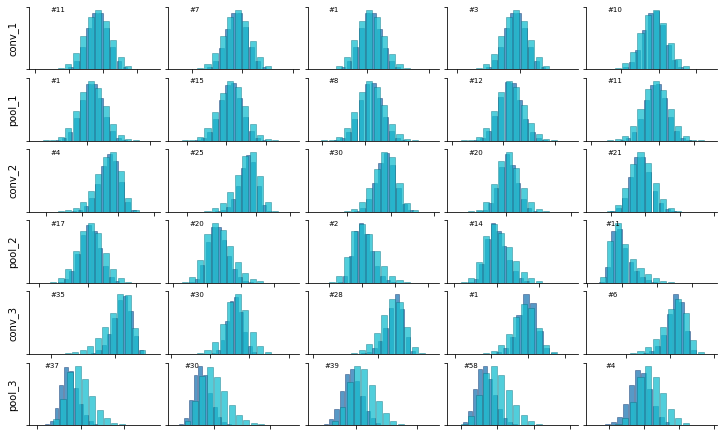

In [29]:
w, h = 2, 1
rows, cols = len(multi_output), 5
fig,ax = plt.subplots(rows, cols, figsize=(cols*w, rows*h))
for i in range(rows):
    dst = np.abs(np.diff(np.array([multi_output[i][idx,:,:].mean(axis=(0,1)) \
                                   for idx in group_index]), axis=0)).squeeze()
    idx = np.argsort(dst)[::-1]
    tmp = multi_output[i][:, :, idx]
    _,_ = plot_layer_output_hist(tmp, group_index, N_bins=16, ax=ax[i], labels=[f'#{j}' for j in idx])
    ss = model.layers[i+1].name.split('_')
    lbl = '_'.join([ss[2], ss[4]])
    ax[i,0].set_ylabel(lbl)
fig.tight_layout(pad=0.5)
# fig.savefig(f'layer_outputs_distr_{experiment_ID}.pdf')

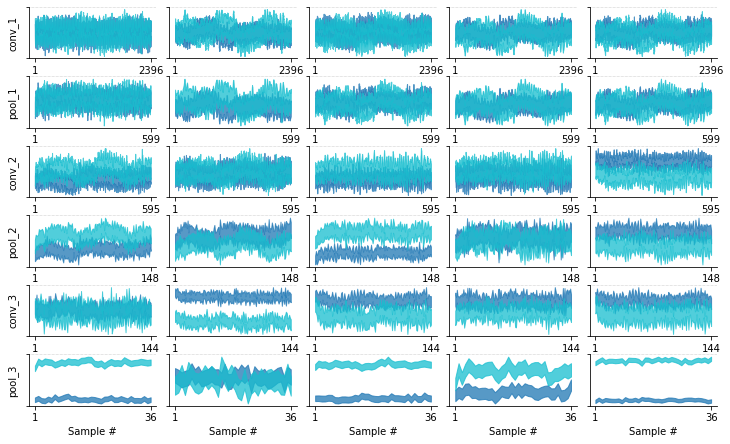

In [30]:
w, h = 2, 1
rows, cols = len(multi_output), 5
fig,ax = plt.subplots(rows, cols, figsize=(cols*w, rows*h))
for i in range(rows):
    _,_ = plot_layer_output_ci(multi_output[i], group_index, ax=ax[i])
    ss = model.layers[i+1].name.split('_')
    lbl = '_'.join([ss[2], ss[4]])
    ax[i,0].set_ylabel(lbl)
for j in range(cols):
    ax[-1,j].set_xlabel('Sample #')
fig.tight_layout(pad=0.1)